#### Version 5:  
_This is the second version of the model. This is developed with variables removed from the initial list. This was developed after omitting the following columns: MS SubClass, MS Zoning, Miscellaneous Features, Exterior 1st, Exterior 2nd, Lot Area, Condition 2, Above Ground Living Area, Foundation Type, and Heating Type_

### Imports and Data Reading

In [43]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [44]:
# Make sure you use the CLEANED csv's! 

train = pd.read_csv("./datasets/train_cleaned.csv")
test = pd.read_csv("./datasets/test_cleaned.csv")

# including these in case I get rid of columns I want to get back O___o

train_source = pd.read_csv("./datasets/train_cleaned.csv")
test_source = pd.read_csv("./datasets/test_cleaned.csv")

### Attribute Selection and Dummifying 

As a reminder, here are the traits identified during EDA to use in the model:

**Categorical/Discrete:** Number of Rooms, Neighborhood, House Style, Basement Condition, Heating Type, Electricity Type, Garage Type, Pool Quality, MS SubClass, MS Zoning, Utility Type, Proximity to Conditions (1 and 2), Exterior Covering (1 and 2), Building Foundation Type, Miscellaneous Feature, Kitchen Quality

**Numerical/Continuous:** House Age, Remodel Age, Above Ground Living Area, Total Square Footage Available, Lot Area, Overall Quality/Condition Average

**Total Number of Variables (excluding trait dummying):** 24

In [45]:
# to start, let's isolate the columns we want to keep 

keep_test = ["Id", "Utilities", "Neighborhood", "Condition 1",
        "House Style", "Bsmt Cond", "Electrical", 
        "Kitchen Qual", "TotRms AbvGrd", "Garage Type", "Pool QC","Total SF",
        "Overall Qu Co Avg", "Age Sold", "Remodel Age"]

keep_train = keep_test + ["SalePrice"]

In [46]:
train = train[keep_train]

test = test[keep_test]

In [47]:
# define a function for dummifying all the categorical traits 

def dummify(df, column, prefix): 
    return pd.get_dummies(df, columns = [f"{column}"], prefix = f"{prefix}", drop_first = True)

In [48]:
# dummify the categoricals 

categoricals = ["Utilities", "Neighborhood", "Condition 1",
                "House Style", "Electrical", 
                "Kitchen Qual", "Garage Type"]
prefixes = ["Util", "Neighborhood", "Cond", "Style",
            "Elec", "Kitchen", "Garage"]

for cat in range(len(categoricals)): 
    train = dummify(train, f"{categoricals[cat]}", f"{prefixes[cat]}")
    
for cat in range(len(categoricals)): 
    test = dummify(test, f"{categoricals[cat]}", f"{prefixes[cat]}")

In [49]:
# fill in numerical values for ranked columns 

train["Pool QC"].fillna(value = "NA", inplace = True)
test["Pool QC"].fillna(value = "NA", inplace = True)

train["Bsmt Cond"].fillna(value = "NA", inplace = True)
test["Bsmt Cond"].fillna(value = "NA", inplace = True)

train["Bsmt Cond"].replace(to_replace = {"Ex" : 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}, inplace = True)
train["Bsmt Cond"].astype('int')
test["Bsmt Cond"].replace(to_replace = {"Ex" : 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}, inplace = True)
test["Bsmt Cond"].astype('int')

train["Pool QC"].replace(to_replace = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "NA": 0}, inplace = True)
train["Pool QC"].astype('int')
test["Pool QC"].replace(to_replace = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "NA": 0}, inplace = True)
test["Pool QC"].astype('int'); 

In [50]:
# remove outliers from training set identified in EDA section 

train = train[(train["Total SF"] < 10000)]

In [51]:
train.shape

(2049, 65)

In [52]:
test.shape

(878, 61)

In [53]:
# the columns are different now. 
# UGGGGHHHHHHHHHHHH

In [54]:
# identify columns that are missing from one set but present in another 
# these are from when we dummified the categoricals
# so columns will be created and filled with 0's 

needed_test = [col for col in train.columns if col not in test.columns]

needed_test.remove("SalePrice")

needed_train = [col for col in test.columns if col not in train.columns]

for col in range(len(needed_test)): 
    test[f"{needed_test[col]}"] = 0 * len(test["Age Sold"])
    
for col in range(len(needed_train)): 
    train[f"{needed_train[col]}"] = 0 * len(train["Age Sold"])

In [55]:
test.shape

(878, 65)

In [56]:
train.shape

(2049, 66)

In [57]:
# Now the columns match up
# yay. 

### Feature Assignment and Splitting

In [58]:
# define variables

X = train.drop(columns = ["Id", "SalePrice"])

y = train["SalePrice"]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 69)

# cannot stratify -- it got mad, there was only one instance of certain traits (due to dummifying)
# changed random state because 42 was giving me some weird numbers, and after trying 123 69 was the tie breaker

### Modeling

#### Linear Regression 

In [60]:
# classic linear regression model 

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
cross_val_score(model, X_train, y_train, cv = 12).mean()

0.8563571451103135

In [62]:
cross_val_score(model, X_test, y_test, cv = 12).mean()

# there is a difference of about 0.1 between my R^2 values--try other regressions for more aligned outcomes

0.8656868262206027

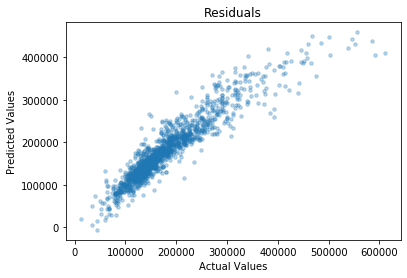

In [63]:
y_preds = model.predict(X_train)


plt.figure(figsize = (6, 4))
plt.scatter(y_train, y_preds, s = 12, alpha = 0.3)
plt.title("Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values"); 

#### Scaled Linear Regression

In [64]:
ss = StandardScaler()

ss.fit(X_train)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [65]:
X_train_sc = ss.transform(X_train)

In [66]:
X_test_sc = ss.transform(X_test)

In [67]:
model2 = LinearRegression()

model2.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
cross_val_score(model2, X_train_sc, y_train, cv = 12)

array([ 8.29043774e-01,  8.08003386e-01,  8.50793607e-01,  8.66251574e-01,
        8.53188530e-01,  8.57031172e-01,  9.05017733e-01,  8.75944134e-01,
       -2.70938575e+22,  8.79578315e-01, -8.51474027e+24, -1.31561965e+21])

In [69]:
cross_val_score(model2, X_train_sc, y_train, cv = 12).mean()

-7.119291459118781e+23

In [70]:
cross_val_score(model2, X_test_sc, y_test, cv = 12)

# well, this clearly isn't working

array([ 7.26480774e-01,  8.76826668e-01,  8.23320565e-01, -3.50263705e+20,
        4.86289831e-01,  8.52533219e-01,  8.75588149e-01, -2.10181418e+19,
        8.80391701e-01,  8.87306729e-01, -1.24751156e+23, -5.95300003e+22])

In [71]:
cross_val_score(model2, X_test_sc, y_test, cv = 12).mean()

-1.5387703172769075e+22

#### LASSO Regression

In [72]:
lasso = LassoCV(cv = 5, alphas = np.logspace(0, 3, 100))

lasso.fit(X_train_sc, y_train)

LassoCV(alphas=array([   1.        ,    1.07226722,    1.149757  ,    1.23284674,
          1.32194115,    1.41747416,    1.51991108,    1.62975083,
          1.7475284 ,    1.87381742,    2.009233  ,    2.15443469,
          2.3101297 ,    2.47707636,    2.65608778,    2.84803587,
          3.05385551,    3.27454916,    3.51119173,    3.76493581,
          4.03701726,    4.32876128,    4.64158883,    4.97702356,
          5.33669923,    5.72236766,    6.13590727,    6.57933225,
          7.05480231,    7.56463328,    8.11130831,    8...
        351.11917342,  376.49358068,  403.70172586,  432.87612811,
        464.15888336,  497.70235643,  533.66992312,  572.23676594,
        613.59072734,  657.93322466,  705.48023107,  756.46332755,
        811.13083079,  869.74900262,  932.60334688, 1000.        ]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None,

In [73]:
cross_val_score(lasso, X_train_sc, y_train, cv = 12).mean()

0.8566097267596479

In [74]:
cross_val_score(lasso, X_test_sc, y_test, cv = 12).mean()

# R^2 values are much closer together now, and remained pretty high

0.8579028583553461

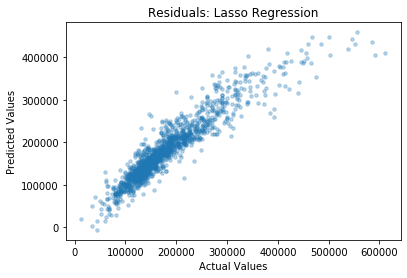

In [75]:
y_lasso_preds = lasso.predict(X_train_sc)

plt.figure(figsize = (6, 4))

plt.scatter(y_train, y_lasso_preds, s = 12, alpha = 0.3)
plt.title("Residuals: Lasso Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values"); 

#### Ridge Regression

In [76]:
ridge = RidgeCV()

ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [77]:
cross_val_score(ridge, X_train_sc, y_train, cv = 12).mean()

0.8563350906175812

In [78]:
cross_val_score(ridge, X_test_sc, y_test, cv = 12).mean()

# cross val score for train set is almost same with Ridge as with Lasso 
# Lasso performed better with test set 

0.8626747718202049

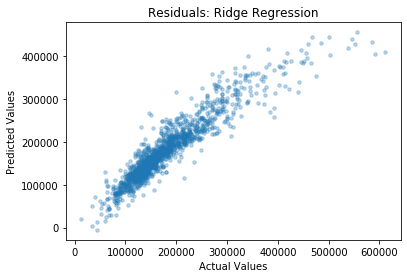

In [79]:
y_ridge_preds = ridge.predict(X_train_sc)

plt.figure(figsize = (6, 4))

plt.scatter(y_train, y_ridge_preds, s = 12, alpha = 0.3)
plt.title("Residuals: Ridge Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values"); 

### Summary : Version 5
This version had **Lasso Regression** as the best performing regression model. 
 - Train $R^2$ = 0.857
 - Test $R^2$ = 0.858
 
Other regression models performed as such: 
 - **Ridge Regression** 
   - Train $R^2$ = 0.856
   - Test $RR^2$ = 0.863
 - **Linear Regression**
   - Train $R^2$ = 0.856
   - Test $R^2$ = 0.866
 - **Scaled Linear Regression** 
   - Train $R^2$ = practically zero
   - Test $R^2$ = practically zero 

#### Exporting Predictions for Kaggle 

Similarity of scores across training and test sets in addition to simplicity (compared to starting point) motivated determination to submit predictions from this model to Kaggle competition. 

In [81]:
test_noId = test.drop(columns = ["Id"])

In [82]:
y_preds_test = lasso.predict(test_noId)

In [83]:
test["SalePrice"] = y_preds_test

In [85]:
test.head()

,Id,Bsmt Cond,TotRms AbvGrd,Pool QC,Total SF,Overall Qu Co Avg,Age Sold,Remodel Age,Util_NoSewr,Neighborhood_Blueste,...,Garage_Attchd,Garage_Basment,Garage_BuiltIn,Garage_CarPort,Garage_Detchd,Util_NoSeWa,Neighborhood_GrnHill,Neighborhood_Landmrk,Elec_Mix,SalePrice
0,2658,3,9,0,2948,7.0,96,56,0,0,...,0,0,0,0,1,0,0,0,0,1.096081e+08
1,2718,3,10,0,3934,4.5,29,29,0,0,...,1,0,0,0,0,0,0,0,0,1.475576e+08
2,2414,4,7,0,2150,6.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8.100967e+07
3,1989,3,5,0,1936,5.5,84,1,0,0,...,0,0,0,0,1,0,0,0,0,7.183542e+07
4,625,3,6,0,2788,5.5,46,46,0,0,...,1,0,0,0,0,0,0,0,0,1.042609e+08


In [87]:
rem = list(test.columns)

rem.remove("Id")
rem.remove("SalePrice")

test_preds = test.drop(columns = rem)

In [89]:
test_preds.shape

(878, 2)

In [91]:
test_preds.to_csv("./datasets/kaggle_sub_v5", index = False)